### Libraries and Helper Functions

In [4]:
from scapy.all import rdpcap, IP, TCP
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [1]:
def get_connection_key(packet):
    """Generate a consistent connection key: (client_ip, server_ip, client_port, server_port)."""
    if packet[TCP].dport == 8080:  # Client to server (server port is 8080)
        return (packet[IP].src, packet[IP].dst, packet[TCP].sport, packet[TCP].dport)
    else:  # Server to client
        return (packet[IP].dst, packet[IP].src, packet[TCP].dport, packet[TCP].sport)

In [24]:
def plot_durations(start_times, durations, attack_start, attack_end, poisons):
    """Plot connection durations against start times with attack period markers."""
    plt.figure(figsize=(12, 6))
    plt.ylim(-5, 105)
    plt.scatter(start_times, durations, s=10, color='blue', label='Legitimate\nConnections')
    plt.scatter(np.array(start_times)[poisons], np.array(durations)[poisons], marker='x', s=5, color='black', label='Excessive\nSYN Packets', alpha=0.3)
    plt.axvline(x=attack_start, color='red', linestyle='--', label='Attack Start')
    plt.axvline(x=attack_end, color='green', linestyle='--', label='Attack End')
    plt.xlabel('Time since capture start (seconds)')
    plt.ylabel('Connection Duration (seconds)')
    plt.title('TCP Connection Durations During SYN Flood Attack')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [25]:
def process_pcap(pcap_file):
    """Process the PCAP file to extract TCP connection durations."""
    packets = rdpcap(pcap_file)
    
    # Dictionary to store connection info: start time, FIN-ACK time, end time
    connections = defaultdict(lambda: {'start': None, 'fin_ack': None, 'end': None, 'poison': None})
    for packet in packets:
        if packet.haslayer(TCP) and packet.haslayer(IP):
            key = get_connection_key(packet)
            flags = packet[TCP].flags
            
            # Start time: First SYN from client (flags == 'S' only, not SYN-ACK)
            if flags == 'S' and connections[key]['start'] is None:
                connections[key]['start'] = packet.time
            
            # FIN-ACK: Record first FIN packet
            if 'F' in flags and connections[key]['fin_ack'] is None:
                connections[key]['fin_ack'] = packet.time
            
            # ACK after FIN-ACK: Set end time
            if 'A' in flags and connections[key]['fin_ack'] is not None and connections[key]['end'] is None:
                connections[key]['end'] = packet.time
            
            # RESET: Set end time if present
            if 'R' in flags and connections[key]['end'] is None:
                connections[key]['end'] = packet.time
        
            if hasattr(packet[TCP], 'load') and packet[TCP].load == b'X' * 120:
                connections[key]['poison'] = True
    
    # Calculate durations and collect data for plotting
    start_times = []
    durations = []
    poisons = []
    i = 0
    for key, info in connections.items():
        if info['start'] is not None:
            if info['end'] is not None:
                duration = info['end'] - info['start']
            else:
                duration = 100  # Default duration if no end time
            start_times.append(info['start'])
            durations.append(duration)

            if info['poison']:
                poisons.append(i)
            i += 1
    
    # Determine attack period relative to capture start
    if packets:
        first_time = packets[0].time
    else:
        print("No packets in PCAP")
        return
    
    # Normalize start times relative to capture start
    start_times_rel = [t - first_time for t in start_times]
    
    # Plot the results
    plot_durations(start_times_rel, durations, 20, 120, poisons)

### Without SYN-FLOOD Mitiagation 

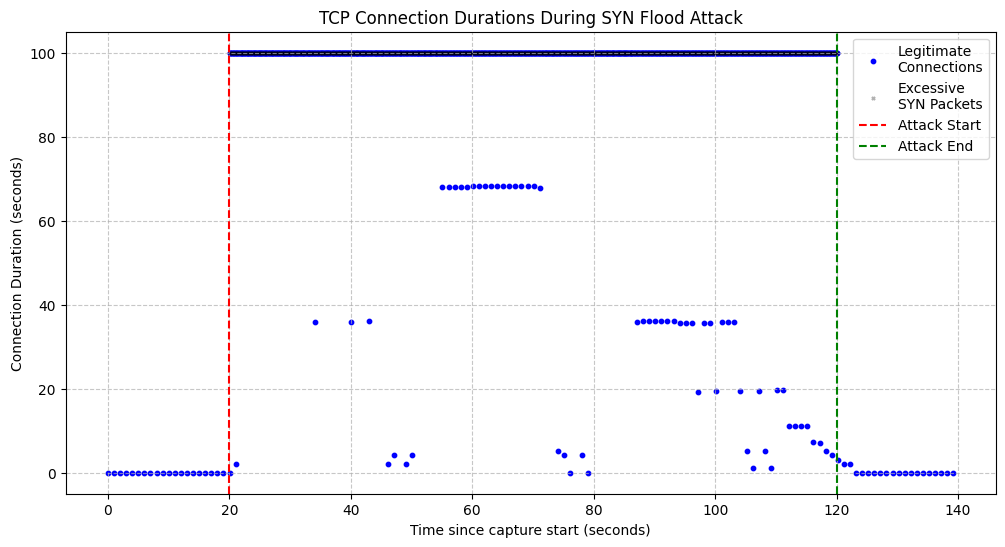

In [26]:
pcap_file = 'capture_syn_flood.pcap'
process_pcap(pcap_file)

### With SYN-FLOOD Mitiagation 

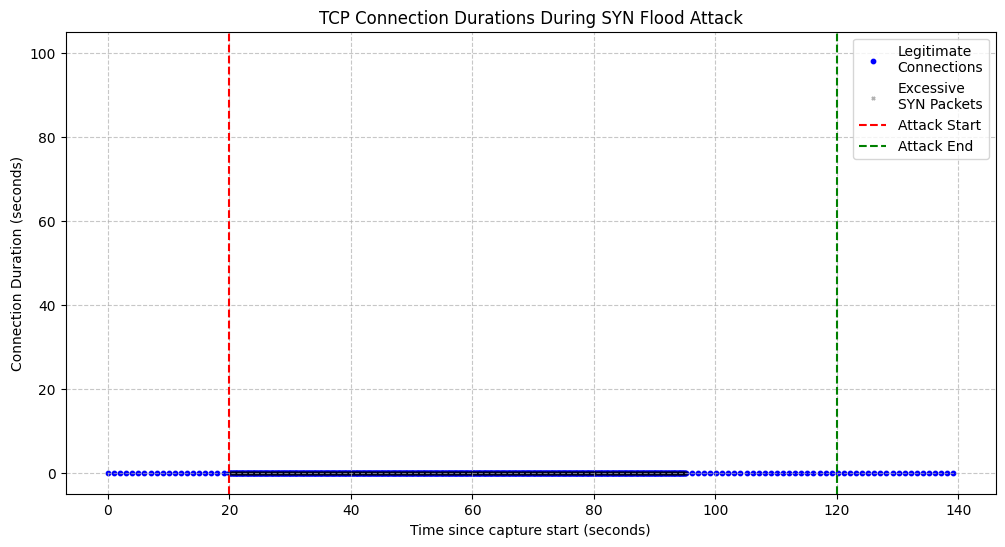

In [27]:
pcap_file = 'capture_mitigated.pcap'
process_pcap(pcap_file)